In [10]:
import os
import sys
import pandas as pd
import glob
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../"))

In [11]:
import os
from data_generation.aircraft_data_generator import Aircraft , Fleet
from federated.centralized_server import CentralizedServer, FederatedClient


In [12]:
# Création d'une flotte de 5 avions, avec 1 avion contenant une anomalie
fleet = Fleet(
    fleet_id=1,
    num_aircraft=5,
    num_anomalous=1,         # Injecter UNE anomalie
    num_points=100,
    interval_minutes=5
)

fleet.generate_fleet_data()

Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_1_normal.csv
Aircraft 1-1 dataset generated (Normal) in fleet 1
Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_2_normal.csv
Aircraft 1-2 dataset generated (Normal) in fleet 1
Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_3_normal.csv
Aircraft 1-3 dataset generated (Normal) in fleet 1
Anomaly 'engine_stall' added from time 2025-01-01 04:58:00 to 2025-01-01 05:18:00 for aircraft 1-4
Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_4_anomalous.csv
Aircraft 1-4 dataset generated (Anomalous) in fleet 1
Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_5_normal.csv
Aircraft 1-5 dataset generated (Normal) in fleet 1
Anomaly summary saved for fleet 1


In [13]:
# Liste des fichiers générés pour cette flotte
csv_files = glob.glob("../data/aircraft_data/fleet_1/aircraft_*.csv")
csv_files.sort()

print("Fichiers détectés :")
for file in csv_files:
    print(file)


Fichiers détectés :
../data/aircraft_data/fleet_1\aircraft_1_1_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_2_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_3_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_4_anomalous.csv
../data/aircraft_data/fleet_1\aircraft_1_5_normal.csv


In [14]:
# Chaque client est un avion avec son fichier CSV
clients = []

for idx, path in enumerate(csv_files):
    clients.append(FederatedClient(client_id=idx, file_paths=[path]))

print(f"{len(clients)} clients créés.")


5 clients créés.


In [15]:
# Serveur fédéré avec tous les clients
server = CentralizedServer(clients)


In [16]:
# Entraînement FL avec FedAvg
server.train(
    rounds=10,           # Nombre de rounds fédérés
    local_epochs=100,     # Nombre d'époques locales par client
    lr=1e-3            # Taux d'apprentissage
)



📡 ROUND 1/10
Client 0 - Entraînement local...
Epoch [1/100] - Loss: 0.2359
Epoch [2/100] - Loss: 0.2077
Epoch [3/100] - Loss: 0.1818
Epoch [4/100] - Loss: 0.1591
Epoch [5/100] - Loss: 0.1385
Epoch [6/100] - Loss: 0.1199
Epoch [7/100] - Loss: 0.1036
Epoch [8/100] - Loss: 0.0886
Epoch [9/100] - Loss: 0.0749
Epoch [10/100] - Loss: 0.0635
Epoch [11/100] - Loss: 0.0535
Epoch [12/100] - Loss: 0.0464
Epoch [13/100] - Loss: 0.0411
Epoch [14/100] - Loss: 0.0379
Epoch [15/100] - Loss: 0.0366
Epoch [16/100] - Loss: 0.0360
Epoch [17/100] - Loss: 0.0356
Epoch [18/100] - Loss: 0.0353
Epoch [19/100] - Loss: 0.0353
Epoch [20/100] - Loss: 0.0350
Epoch [21/100] - Loss: 0.0348
Epoch [22/100] - Loss: 0.0346
Epoch [23/100] - Loss: 0.0344
Epoch [24/100] - Loss: 0.0343
Epoch [25/100] - Loss: 0.0341
Epoch [26/100] - Loss: 0.0339
Epoch [27/100] - Loss: 0.0337
Epoch [28/100] - Loss: 0.0334
Epoch [29/100] - Loss: 0.0333
Epoch [30/100] - Loss: 0.0330
Epoch [31/100] - Loss: 0.0327
Epoch [32/100] - Loss: 0.0326
Ep

In [ ]:
# Cellule Jupyter
from IPython.display import display

bench = server.benchmark_all_clients()
display(bench)              


,client_id,mean_mse,max_mse,std_mse,n_points
0,3,0.024995,0.094673,0.020248,100
1,4,0.022113,0.090655,0.021101,100
2,2,0.019180,0.103088,0.018266,100
3,0,0.017616,0.130885,0.021463,100
4,1,0.016429,0.064163,0.016200,100


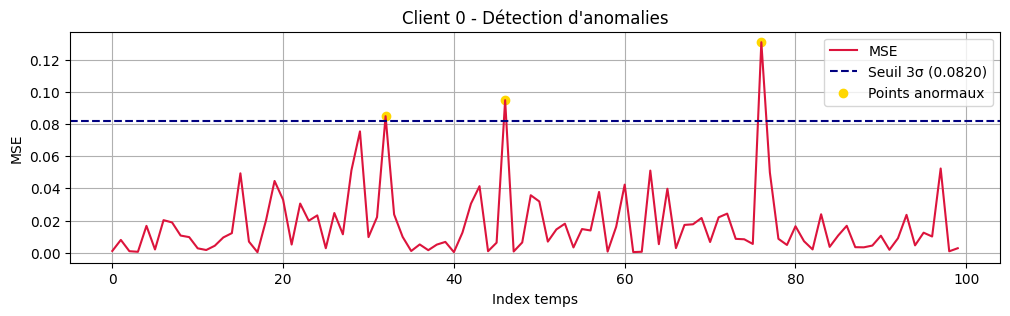

In [19]:
import numpy as np

client_id = 0   # ex.
errs, th, _ = server.evaluate_client(client_id)

plt.figure(figsize=(12,3))
plt.plot(errs, label='MSE', color='crimson')
plt.axhline(th, color='navy', linestyle='--', label=f'Seuil 3σ ({th:.4f})')
plt.scatter(np.where(errs > th), errs[errs > th],
            color='gold', label='Points anormaux')
plt.title(f"Client {client_id} - Détection d'anomalies")
plt.xlabel("Index temps")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()
